In [ ]:
# default_exp subcoco_lightning_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Pytorch Lightning Specific Utilities

Extracted common utilities for all Pytorch Lightning related data loading stuff

In [ ]:
#export
import cv2, json, os, requests, sys, tarfile, torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import random
import torch.nn.functional as F
import torch.multiprocessing

from collections import defaultdict
from functools import reduce
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection import RetinaNet, retinanet_resnet50_fpn

from torchvision import transforms

from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

import albumentations as A
import pytorch_lightning as pl
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningDataModule
from mcbbox.subcoco_utils import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}, Albumentation {A.__version__}")

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.0, pytorch_lightning 1.0.4, Albumentation 0.5.0


In [ ]:
#hide
img_sz, bs, acc, workers, head_runs, full_runs = 128, 4, 8, 1, 1, 1
datadir, url, img_subdir = '/tmp', 'http://files.fast.ai/data/examples/coco_tiny.tgz', 'train'
stem = Path(url).stem
img_dir=f'{datadir}/{stem}/{img_subdir}'
train_json = fetch_subcoco(datadir=datadir, url=url, img_subdir=img_subdir)
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Wrap Data Loading Logic using Pytorch-Lightning

In order to use Pytorch Lightning to load data, we need to define a DataModule to encapsulate all the data loading logic. At first I thought I can reuse CocoDetect() from torchvision but it uses cocoapi downstream and expects json annotation file to be of this [format](https://cocodataset.org/#format-data):
```
annotation{
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}
```

Tiny and Sample Coco's train.json file only has a subset of the above fields:
```
“Annotations”: [
    {
      "image_id": 542959,
      "bbox": [
        32.52,
        86.34,
        8.53,
        9.41
      ],
      "category_id": 62
    },
    ...
]
``` 

Thus we will need to make a Dataset to handle it properly.

In [ ]:
# export
class SubCocoDataset(torchvision.datasets.VisionDataset):
    """
    Simulate what torchvision.CocoDetect() returns for target given fastai's coco subsets
    Args:
        root (string): Root directory where images are downloaded to.
        stats (CocoDatasetStats):
    """

    def __init__(self, root:str, stats:CocoDatasetStats, img_ids:list=[], bbox_aware_tfms:callable=None):
        super(SubCocoDataset, self).__init__(root) 
        self.stats = stats
        self.img_ids = []
        n_missing = 0
        for img_id in img_ids:
            img_fname = stats.img2fname[img_id]
            if not os.path.isfile(stats.img_dir/img_fname):
                n_missing += 1
            elif stats.img2sz.get(img_id, None) is None:
                n_missing += 1
            else:
                img_w, img_h = stats.img2sz[img_id]
                l2bs = stats.img2l2bs[img_id]
                safe_l2bs = {}
                for l, bs in l2bs.items():
                    safe_bs = []
                    for bx, by, bw, bh in bs:
                        if box_within_bounds(bx, by, bw, bh, img_w, img_h, .01, .01):
                            safe_bs.append((bx, by, bw, bh))
                    if len(safe_bs) > 0:
                        safe_l2bs[l] = safe_bs
                if len(safe_l2bs) <= 0:
                    n_missing += 1
                else:
                    stats.img2l2bs[img_id] = safe_l2bs
                    self.img_ids.append(img_id)
                    
        if n_missing > 0 : print(f'Warning: {n_missing} image files are missing or have unsafe boxes!!!')
        self.bbox_aware_tfms = bbox_aware_tfms

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        img_id = self.img_ids[index] if index < len(self.img_ids) else 0
        img_fname = self.stats.img2fname.get(img_id, None)
        if img_id is None or img_fname ==None:
            return (None, None)
        img_fpath = os.path.join(self.root, img_fname)
        img_w, img_h = self.stats.img2sz.get(img_id, (1,1))
        target = { 'boxes': [], 'labels': [], 'image_id': img_id, 'width': img_h, 'height': img_h, 'areas': [], 'iscrowds': 0, 'ids': [] }
        count = 0
        lbs = self.stats.img2lbs.get(img_id,[])
        for l, x, y, w, h in lbs:
            count += 1
            target['boxes'].append([x, y, x+w, y+h]) # FRCNN and RetNet wants x1,y1,x2,y2 format!
            target['labels'].append(l)
            target['areas'].append(w*h)
            anno_id = img_id*1000 + count
            target['ids'].append(anno_id)

        img = cv2.imread(img_fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.bbox_aware_tfms is not None:
            transformed = self.bbox_aware_tfms(image=img, bboxes=target['boxes'], class_labels=target['labels'])
            img = transformed['image']
            target['boxes'] = transformed['bboxes']

        for k, v in target.items():
            target[k] = torch.tensor(v, dtype=(torch.float if k in ['boxes', 'width', 'height', 'areas'] else torch.long))
        
        img = torch.from_numpy(img/255.0).float().permute(2, 0, 1)
        return img, target

    def __len__(self):
        return len(self.img_ids)

Test w/o Augmentations

img =
tensor([[[0.5922, 0.6000, 0.6039,  ..., 0.2039, 0.2000, 0.2000],
         [0.5843, 0.5882, 0.5961,  ..., 0.2039, 0.2000, 0.1961],
         [0.5725, 0.5804, 0.5843,  ..., 0.2039, 0.2000, 0.1961],
         ...,
         [0.7098, 0.7373, 0.7569,  ..., 0.0667, 0.0941, 0.0667],
         [0.7412, 0.7529, 0.7765,  ..., 0.0235, 0.0392, 0.0196],
         [0.7725, 0.7647, 0.7804,  ..., 0.0157, 0.0392, 0.0902]],

        [[0.6784, 0.6863, 0.6902,  ..., 0.5686, 0.5647, 0.5647],
         [0.6706, 0.6745, 0.6824,  ..., 0.5686, 0.5647, 0.5608],
         [0.6588, 0.6667, 0.6706,  ..., 0.5647, 0.5608, 0.5569],
         ...,
         [0.6745, 0.6941, 0.6980,  ..., 0.1216, 0.1176, 0.0824],
         [0.7098, 0.7137, 0.7216,  ..., 0.0627, 0.0510, 0.0157],
         [0.7529, 0.7333, 0.7255,  ..., 0.0510, 0.0353, 0.0784]],

        [[0.7725, 0.7804, 0.7843,  ..., 0.3608, 0.3569, 0.3569],
         [0.7647, 0.7686, 0.7765,  ..., 0.3608, 0.3569, 0.3529],
         [0.7529, 0.7608, 0.7647,  ..., 0.3647, 0.36

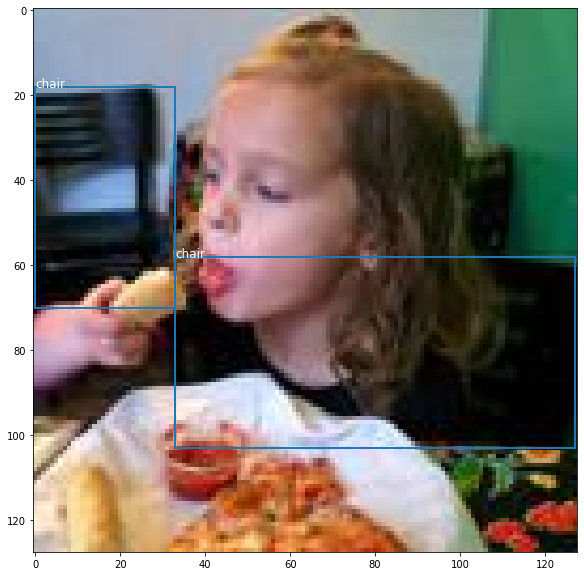

In [ ]:
#hide
best_img_pos = 89
dataset = SubCocoDataset(img_dir, stats, img_ids=list(stats.img2sz.keys()))
img,tgt = dataset[best_img_pos]
print(f"img =\n{img}\ntgt =\n{tgt}")
tgt_l2bs = defaultdict(empty_list)
n_boxs = 0
for l, b in zip(list(tgt['labels']), tgt['boxes']):
    n_boxs +=1
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

print(f"n_boxs = {n_boxs}")
pimg = torchvision.transforms.ToPILImage()(img)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

Verify the image transformation works using Albumentation, especially random transform to both image and target.

n_boxs = 2


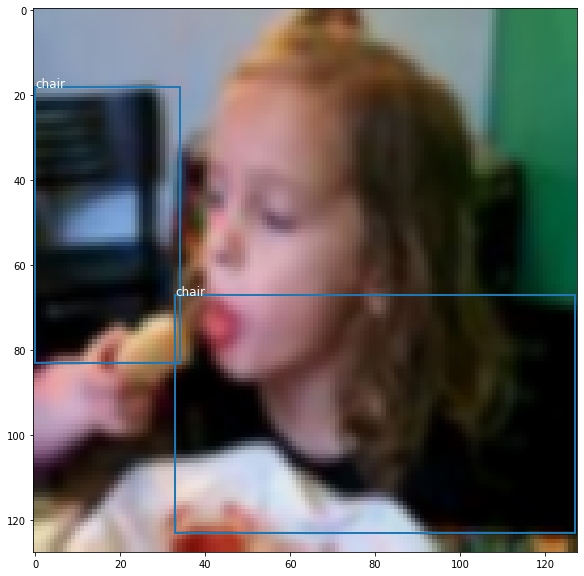

In [ ]:
#hide
tfms = A.Compose([
    A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9),
    A.RandomSizedBBoxSafeCrop(width=128,height=128),
    A.HorizontalFlip(p=0.5), 
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.Blur(blur_limit=(1, 3)),
#     A.Normalize(mean=stats.chn_means/255, std = stats.chn_stds/255), #why is this fucked up?
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

dataset = SubCocoDataset(img_dir, stats, img_ids=list(stats.img2sz.keys()), bbox_aware_tfms=tfms) 
img, tgt = dataset[best_img_pos]
tgt_l2bs = defaultdict(empty_list)
n_boxs = 0
for l, b in zip(list(tgt['labels']), tgt['boxes']):
    n_boxs +=1
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

print(f"n_boxs = {n_boxs}")
pimg = torchvision.transforms.ToPILImage()(img)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

## Custom DataModule

In [ ]:
#export
class SubCocoDataModule(LightningDataModule):

    def __init__(self, root, stats, bs=32, workers=4, split_ratio=0.8, shuffle=True, 
                 train_transforms=None, val_transforms=None):
        super().__init__(train_transforms=train_transforms, val_transforms=val_transforms)
        self.dir = root
        self.bs = bs
        self.workers = workers
        self.stats = stats
        self.split_ratio = split_ratio
        self.shuffle = shuffle

        num_items = stats.num_imgs
        num_train = int(self.split_ratio*num_items)
        img_ids = list(stats.img2sz.keys())
        if shuffle: random.shuffle(img_ids)
            
        train_img_ids = img_ids[:num_train]
        val_img_ids = img_ids[num_train:]
        
        self.train = SubCocoDataset(self.dir, self.stats, img_ids=train_img_ids, bbox_aware_tfms=train_transforms) 
        self.val = SubCocoDataset(self.dir, self.stats, img_ids=val_img_ids, bbox_aware_tfms=val_transforms)
        
    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn, shuffle=False)

In [ ]:
#hide
tiny_coco_dm = SubCocoDataModule(img_dir, stats, bs=2, train_transforms=tfms, val_transforms=tfms)
tdl=tiny_coco_dm.train_dataloader()
images, targets = next(iter(tdl))

len(images), len(targets), images[0], targets[0]

(2,
 2,
 tensor([[[0.8078, 0.8235, 0.8431,  ..., 0.8314, 0.8353, 0.8353],
          [0.8118, 0.8235, 0.8353,  ..., 0.8392, 0.8431, 0.8314],
          [0.8157, 0.8196, 0.8275,  ..., 0.8392, 0.8275, 0.8118],
          ...,
          [0.7686, 0.7725, 0.7804,  ..., 0.6196, 0.6157, 0.6118],
          [0.7686, 0.7725, 0.7765,  ..., 0.6157, 0.6118, 0.6118],
          [0.7765, 0.7765, 0.7725,  ..., 0.6118, 0.6118, 0.6118]],
 
         [[0.6667, 0.6627, 0.6588,  ..., 0.5569, 0.5843, 0.5922],
          [0.6588, 0.6588, 0.6588,  ..., 0.5608, 0.5882, 0.6000],
          [0.6549, 0.6588, 0.6627,  ..., 0.5608, 0.5882, 0.5961],
          ...,
          [0.4824, 0.4824, 0.4941,  ..., 0.3490, 0.3451, 0.3412],
          [0.4824, 0.4863, 0.4902,  ..., 0.3451, 0.3412, 0.3412],
          [0.4902, 0.4902, 0.4863,  ..., 0.3412, 0.3412, 0.3412]],
 
         [[0.7882, 0.7765, 0.7647,  ..., 0.6824, 0.6706, 0.6549],
          [0.7922, 0.7843, 0.7725,  ..., 0.6784, 0.6588, 0.6392],
          [0.7922, 0.7843, 0.772

## Export to Regular Python Script as 'subcoco_lightning_util.py'

In [ ]:
#hide
from nbdev.export import *
notebook2script(fname='20_subcoco_lightning_utils.ipynb')

Converted 20_subcoco_lightning_utils.ipynb.
